# Neural networks in human emotions - an overview, part 3.

Hello and welcome to the final part of the neural networks analysis! Here we will build a **toxicity classifier** module for our program. Mind that we *will* repeat a lot of code which we have already seen in `development_part2.ipynb`, as we most likely will not build new architectures, but analyze their performance on a different dataset.

If you do not think that reading this would, in any way, will be beneficial to you - you can safely skip this notebook.

That being said, let's analyze the dataset we have.

### Analyzing the dataset

Today we only have one dataset, which is the *jigsaw-toxic-comment-classification-challenge* dataset. Let's load it.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df_pre_train = pd.read_csv(filepath_or_buffer="./datasets/toxicity_dataset/train.csv")
df_pre_train.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [12]:
df_pre_test = pd.read_csv(filepath_or_buffer="./datasets/toxicity_dataset/test.csv")
df_pre_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [13]:
df_pre_test_labels = pd.read_csv(filepath_or_buffer="./datasets/toxicity_dataset/test_labels.csv")
df_pre_test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


First thing we might notice about the dataset is that, because this is a dataset from a kaggle competition, we cannot use the test dataset. This is because all of the -1s are "unknown" labels, which do not provide any testing benefit. The kaggle would compare our predicted labels with theirs.

However, because we are not taking part in that competition right now, we will not use the testing dataset. Instead, we will split `df_pre_train` into `df_test` and `df_train`. But before we do that, let's collapse the dataset...

In [14]:
df_pre_train['is_toxic'] = df_pre_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
df_pre_train.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0,0


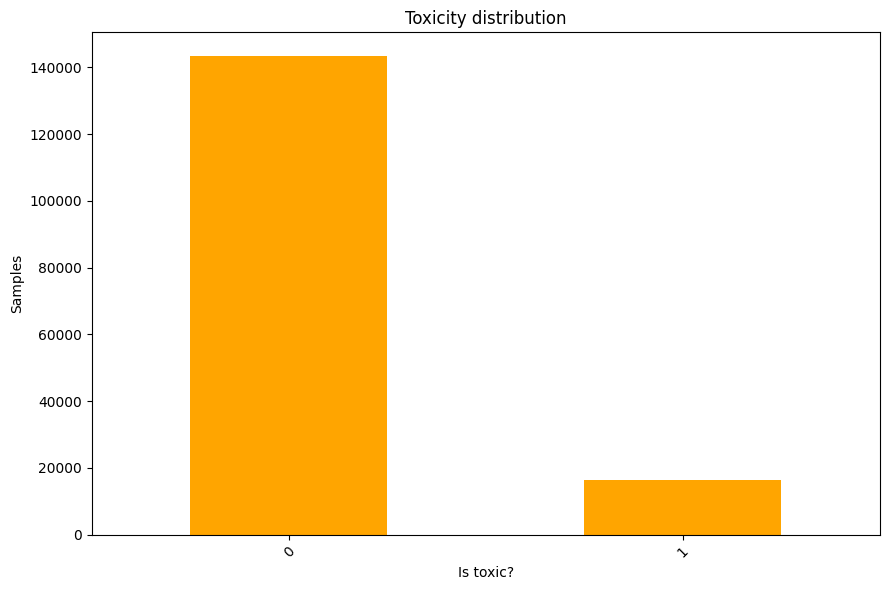

In [15]:
toxic_counts = df_pre_train['is_toxic'].value_counts(normalize=False)
plt.figure(figsize=(9, 6))
toxic_counts.plot(kind='bar', color='orange')
plt.title('Toxicity distribution')
plt.xlabel('Is toxic?')
plt.ylabel('Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

New dataset size: (56225, 9)


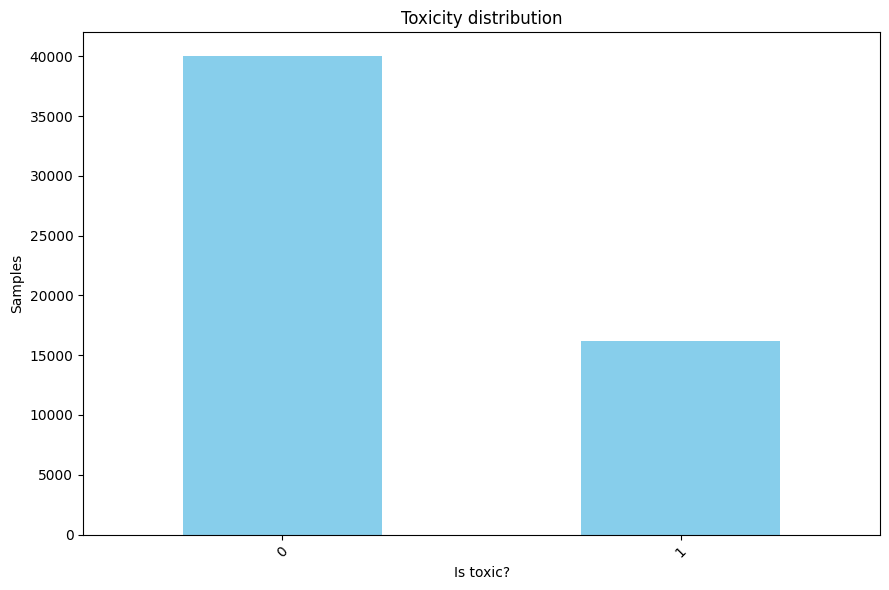

In [16]:
toxic_df = df_pre_train[df_pre_train['is_toxic'] == 1]
non_toxic_df = df_pre_train[df_pre_train['is_toxic'] == 0]

non_toxic_df_capped = non_toxic_df.sample(n=40000, random_state=123)

df_balanced = pd.concat([toxic_df, non_toxic_df_capped]).sample(frac=1, random_state=123).reset_index(drop=True)

print(f"New dataset size: {df_balanced.shape}")
toxic_counts = df_balanced['is_toxic'].value_counts(normalize=False)
plt.figure(figsize=(9, 6))
toxic_counts.plot(kind='bar', color='skyblue')
plt.title('Toxicity distribution')
plt.xlabel('Is toxic?')
plt.ylabel('Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
print(len(toxic_df))

16225


In [18]:
import re
def full_text_cleaning_pipeline(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_balanced['clean_text'] = df_balanced['comment_text'].apply(full_text_cleaning_pipeline)
toxic_df['clean_text'] = toxic_df['comment_text'].apply(full_text_cleaning_pipeline)
non_toxic_df_capped['clean_text'] = non_toxic_df_capped['comment_text'].apply(full_text_cleaning_pipeline)

C:\Users\Kolyamba\AppData\Local\Temp\ipykernel_3216\185767918.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxic_df['clean_text'] = toxic_df['comment_text'].apply(full_text_cleaning_pipeline)


In [19]:
from nlpaug.augmenter.word import SynonymAug
from tqdm.std import TqdmWarning
import warnings

warnings.filterwarnings('ignore', category=TqdmWarning)
warnings.filterwarnings('ignore', category=UserWarning)
augmenter = SynonymAug(aug_src='wordnet', aug_p=0.1)

c:\Users\Kolyamba\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Kolyamba\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [20]:
from tqdm import tqdm
import math
source_texts = []
aug_texts = []
aug_labels = []
percentage = (len(toxic_df) / 100 * 60)
percentage = math.ceil(percentage)
print(percentage)
batch_size = 16
for i in tqdm(range(0, percentage, batch_size)):
    batch = toxic_df.sample(n=batch_size, replace=True, random_state=i)
    texts = batch['clean_text'].tolist()
    labels = batch['is_toxic'].tolist()
    aug_batch = augmenter.augment(texts)
    aug_texts.extend(aug_batch)
    aug_labels.extend(labels)

9735


100%|██████████| 609/609 [00:25<00:00, 23.71it/s]


In [21]:
print(aug_texts[:32])
print(aug_labels[:32])

['nissim cahn vandals ive blocked them all and a couple of other related sockpuppets equally well talk izak thank you for your welcoming remarks on my lecture varlet talk i can and doprommote what you call mashichist views and still try to do it remaining npov as i have actualy done in last few months npov is in the eye of the beholder as well as any other rule see for example the gil students foliate deletion proccess to view examples of extreme bias against him by some of the chabad wikipedians and their attempts to hide that bias by quoting the wikipedia rules or see the reverts of the chabad page and the rebbes varlet by various people and some of the things they posted on the corresponding talk pages to evidence the antimashichist agenda or antimashichist domination of the official chabad', 'avruch you truly do show your coloursthis is a finding of fact and the crown had to pay my dads costs for their stupidity in case you dont understand look up stare decisisjudicial precedentthe

In [22]:
df_augmented_toxic = pd.DataFrame({
    "clean_text": aug_texts,
    "is_toxic": aug_labels
})

In [23]:
non_toxic_df_capped_clean = pd.DataFrame({
    "clean_text": non_toxic_df_capped['clean_text'].copy().tolist(),
    "is_toxic": non_toxic_df_capped['is_toxic'].copy().tolist()
})

In [24]:
toxic_df_clean = pd.DataFrame({
    "clean_text": toxic_df['clean_text'].copy().tolist(),
    "is_toxic": toxic_df['is_toxic'].copy().tolist()
})

In [25]:
df_toxic_result = pd.concat([df_augmented_toxic, toxic_df_clean], ignore_index=True)

df_toxic_result = df_toxic_result.sample(frac=1.0, random_state=123).reset_index(drop=True)

print(len(df_toxic_result))

25969


In [26]:
df_result = pd.concat([df_toxic_result, non_toxic_df_capped_clean], ignore_index=True)

df_result = df_result.sample(frac=1.0, random_state=123).reset_index(drop=True)

In [27]:
df_result.to_csv("toxic_dataset_augmented_balanced.csv", index=False)

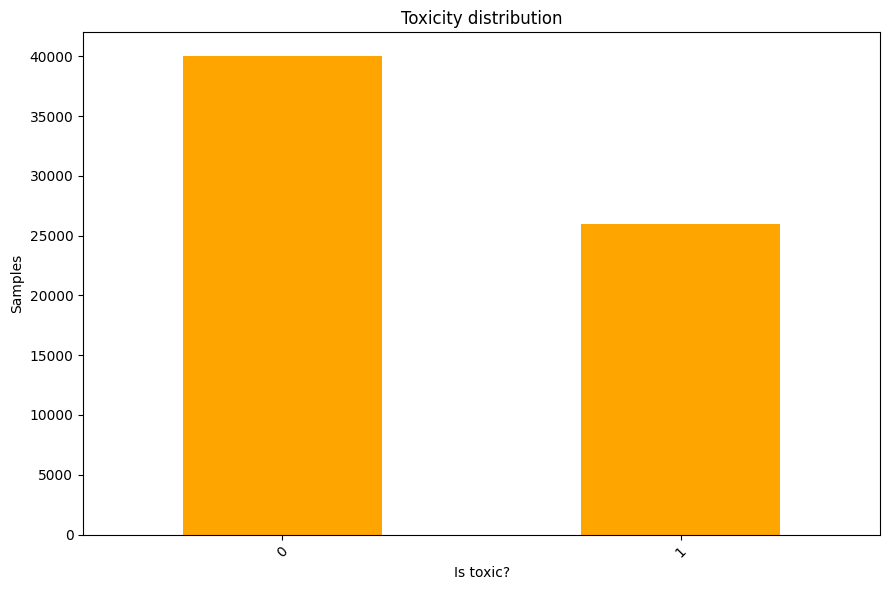

In [28]:
toxic_counts = df_result['is_toxic'].value_counts(normalize=False)
plt.figure(figsize=(9, 6))
toxic_counts.plot(kind='bar', color='orange')
plt.title('Toxicity distribution')
plt.xlabel('Is toxic?')
plt.ylabel('Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
df_train, df_pre_test = train_test_split(df_result, test_size=0.3)

In [21]:
df_test, df_val = train_test_split(df_pre_test, test_size=0.5)

In [22]:
print("Training size:", len(df_train))
print("Validation size:", len(df_val))
print("Test size:", len(df_test))
print("Sentiment distribution:\n", df_result['is_toxic'].value_counts())

Training size: 46178
Validation size: 9896
Test size: 9895
Sentiment distribution:
 is_toxic
0    40000
1    25969
Name: count, dtype: int64


### Building the model

#### Machine learning approaches

Once again, we will go through the accuracy of BoW and TF-IDF on Naive Bayes, Logistic Regression and SGD. Nothing new to see here aside from the accuracies.

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

x_train_data = np.array(df_train['clean_text'])
y_train_data = np.array(df_train['is_toxic'])
x_test_data = np.array(df_test['clean_text'])
y_test_data = np.array(df_test['is_toxic'])

count_vectorizer = CountVectorizer()
x_train = count_vectorizer.fit_transform(x_train_data)
x_test = count_vectorizer.transform(x_test_data)


print("Entries for training: ", x_train.shape)
print("Entries for testing: ", x_test.shape)

Entries for training:  (46178, 87951)
Entries for testing:  (9895, 87951)


In [71]:
modelNB = MultinomialNB()
modelNB.fit(x_train, y_train_data)

y_pred = modelNB.predict(x_test)
print(classification_report(y_test_data, y_pred))
print("Accuracy: ", accuracy_score(y_test_data, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      5963
           1       0.89      0.85      0.87      3932

    accuracy                           0.90      9895
   macro avg       0.90      0.89      0.89      9895
weighted avg       0.90      0.90      0.90      9895

Accuracy:  0.8999494694290046


In [72]:
from sklearn.linear_model import LogisticRegression
modelLR = LogisticRegression(solver="saga", max_iter=1000)
modelLR.fit(x_train, y_train_data)

y_pred = modelLR.predict(x_test)
print(classification_report(y_test_data, y_pred))
print("Accuracy: ", accuracy_score(y_test_data, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      5963
           1       0.82      0.81      0.81      3932

    accuracy                           0.85      9895
   macro avg       0.84      0.84      0.84      9895
weighted avg       0.85      0.85      0.85      9895

Accuracy:  0.8511369378473976


In [75]:
from sklearn.linear_model import SGDClassifier
modelSGDBOW = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)
modelSGDBOW.fit(x_train, y_train_data)

y_pred = modelSGDBOW.predict(x_test)
print(classification_report(y_test_data, y_pred))
print("Accuracy: ", accuracy_score(y_test_data, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      5963
           1       0.94      0.85      0.89      3932

    accuracy                           0.92      9895
   macro avg       0.92      0.91      0.91      9895
weighted avg       0.92      0.92      0.92      9895

Accuracy:  0.9175341081354219


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer


x_train_data = np.array(df_train['clean_text'])
y_train_data = np.array(df_train['is_toxic'])
x_test_data = np.array(df_test['clean_text'])
y_test_data = np.array(df_test['is_toxic'])

tf_idf_vectorizer = TfidfVectorizer()
x_train = tf_idf_vectorizer.fit_transform(x_train_data)
x_test = tf_idf_vectorizer.transform(x_test_data)


print("Entries for training: ", x_train.shape)
print("Entries for testing: ", x_test.shape)

Entries for training:  (46178, 87951)
Entries for testing:  (9895, 87951)


In [28]:
modelNB = MultinomialNB()
modelNB.fit(x_train, y_train_data)

y_pred = modelNB.predict(x_test)
print(classification_report(y_test_data, y_pred))
print("Accuracy: ", accuracy_score(y_test_data, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      5963
           1       0.96      0.71      0.82      3932

    accuracy                           0.87      9895
   macro avg       0.90      0.85      0.86      9895
weighted avg       0.89      0.87      0.87      9895

Accuracy:  0.8735725113693785


In [29]:
from sklearn.linear_model import LogisticRegression
modelLR = LogisticRegression(solver="saga", max_iter=1000)
modelLR.fit(x_train, y_train_data)

y_pred = modelLR.predict(x_test)
print(classification_report(y_test_data, y_pred))
print("Accuracy: ", accuracy_score(y_test_data, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      5963
           1       0.92      0.84      0.88      3932

    accuracy                           0.91      9895
   macro avg       0.91      0.90      0.90      9895
weighted avg       0.91      0.91      0.91      9895

Accuracy:  0.9083375442142496


In [30]:
from sklearn.linear_model import SGDClassifier
modelSGD = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)
modelSGD.fit(x_train, y_train_data)

y_pred = modelSGD.predict(x_test)
print(classification_report(y_test_data, y_pred))
print("Accuracy: ", accuracy_score(y_test_data, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5963
           1       0.91      0.78      0.84      3932

    accuracy                           0.88      9895
   macro avg       0.89      0.86      0.87      9895
weighted avg       0.88      0.88      0.88      9895

Accuracy:  0.8807478524507327


Awesome, already some great accuracies. Let's see about neural networks.

#### Neural Network approaches.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [32]:
tokens = list()
tokens.append("UNK")
tokens.append("PAD")
for item in list(count_vectorizer.vocabulary_):
    count = count_vectorizer.vocabulary_[item]
    if count > 5:
        tokens.append(item)

In [33]:
token_to_id = {token: id for id, token in enumerate(tokens)}
print("Sample values:")
print(tokens[-10:])
print("VOCABULARY LENGTH: ", len(list(token_to_id)))
print()
print("SAMPLE ID OF PAD: ", token_to_id['PAD'])

Sample values:
['onenessi', 'onethe', 'oneand', 'nadana', 'assemblage', 'nonracists', 'commonscategoryhadrosaurus', 'foulkii', 'leidy', 'stickler']
VOCABULARY LENGTH:  87947

SAMPLE ID OF PAD:  1


In [34]:
from gensim.models import KeyedVectors
gen_emb = KeyedVectors.load_word2vec_format("./bow5.vec")

In [35]:
tokens_gen = list()
for key in gen_emb.key_to_index.keys():
    tokens_gen.append(key)

In [36]:
for token in tokens_gen[:20000]:
    if token not in tokens:
        tokens.append(token)

In [37]:
token_to_id = {token: id for id, token in enumerate(tokens)}
print("Sample values:")
print(tokens[-10:])
print("VOCABULARY LENGTH: ", len(list(token_to_id)))
print()
print("SAMPLE ID OF PAD: ", token_to_id['PAD'])

Sample values:
['latex', 'torino', 'cessation', 'sargent', 'leases', 'undivided', 'cultivate', 'partido', 'gables', "o'hara"]
VOCABULARY LENGTH:  90612

SAMPLE ID OF PAD:  1


In [77]:
import pickle

with open("toxic_tokenizer_data.pkl", "wb") as f:
    pickle.dump((tokens, token_to_id), f)

In [39]:
vocab_size = len(tokens)
embedding_matrix = np.zeros((vocab_size, 300)) #300 is the dimension of the embedding!
for word, idx in token_to_id.items():
    if word in gen_emb:
        embedding_matrix[idx] = gen_emb.get_vector(word)
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(300, ))

In [40]:
UNK_IX, PAD_IX = map(token_to_id.get, ["UNK", "PAD"])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [41]:
def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key == 'clean_text' or key == 'is_toxic':
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

In [42]:
def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop]).astype(np.float32)
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [43]:
def make_batch(data, max_len=None, word_dropout=0, device=device):
    batch = {}
    batch['clean_text'] = as_matrix(data['clean_text'].values, max_len)

    if word_dropout != 0:
        batch['clean_text'] = apply_word_dropout(batch['clean_text'], 1. - word_dropout)
    
    if 'is_toxic' in data.columns:
        batch['is_toxic'] = data['is_toxic'].values
    return to_tensors(batch, device)

In [44]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

In [45]:
from tqdm.auto import tqdm
from torch.amp import autocast, GradScaler

In [46]:
def evaluate_model(model, data_test, batch_size, criterion=None):
    model.eval()
    test_correct = 0
    test_examples = 0
    total_val_loss = 0
    avg_val_loss = 0
    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterate_minibatches(data_test, batch_size, device=device, shuffle=False)), total=len(data_test) // batch_size):
            out_data = model(batch['clean_text'])
            targets = batch['is_toxic']
            if criterion:
               loss = criterion(out_data, targets)
            predictions = torch.argmax(out_data, dim=1)
            test_correct += (predictions == targets).sum().item()
            test_examples += targets.size(0)
            if criterion:
                total_val_loss += loss.item()
    test_accuracy = test_correct / test_examples
    if criterion:
        avg_val_loss = total_val_loss / test_examples
    return test_accuracy, avg_val_loss

In [47]:
def train_model(epochs, model, scaler, criterion, optimizer, data_train, data_val, batch_size, scheduler=None, num_unfreeze=3):
    #############################################################################
    ### Returns last_accuracy, total_accuracy, total_loss, total_val_accuracy ###
    #############################################################################
    total_loss = list()
    total_accuracy = list()
    total_val_accuracy = list()
    for epoch in range(epochs):
        total_correct = 0
        total_examples = 0
        total_loss_epoch = 0
        if epoch == num_unfreeze:
            model.embedding.weight.requires_grad = True
        print(f"epoch: ", {epoch})
        model.train()
        for i, batch in tqdm(enumerate(iterate_minibatches(data_train, batch_size, device=device)), total=len(data_train) // batch_size):
            optimizer.zero_grad()
            targets = batch['is_toxic']
            with autocast(device_type=device):
                logits = model(batch['clean_text'])
                loss = criterion(logits, targets)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            predictions = torch.argmax(logits, dim=1)
            correct = (predictions == targets).sum().item()
            total_loss_epoch += loss.item()
            total_correct = total_correct + correct
            total_examples += targets.size(0)

        validation_accuracy, validation_loss = evaluate_model(model, data_val, batch_size, criterion)

        epoch_loss = total_loss_epoch / total_examples
        epoch_accuracy = total_correct / total_examples
        total_loss.append(total_loss_epoch)
        total_accuracy.append(epoch_accuracy)
        total_val_accuracy.append(validation_accuracy)
        if scheduler:
            scheduler.step(validation_loss)
        print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}, Val_accuracy = {validation_accuracy:.4f}, Val_loss = {validation_loss:.4f}")
    return epoch_accuracy, total_accuracy, total_loss, total_val_accuracy

In [48]:
class SentimentClassifierCNN(nn.Module):
    def __init__(self, vocabulary_dim, embedding_matrix, num_sentiments=3):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_dim, 300)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout(0.5)
        self.conv1 = nn.Conv1d(300, 256, 7)
        self.pool1 = nn.AdaptiveAvgPool1d(output_size=128)
        self.conv2 = nn.Conv1d(256, 128, 5)
        self.pool2 = nn.AdaptiveAvgPool1d(output_size=64)
        self.conv3 = nn.Conv1d(128, 64, 3)
        self.pool3 = nn.AdaptiveAvgPool1d(output_size=32)

        self.dropout_conv = nn.Dropout(0.3)

        self.fc1 = nn.Linear(in_features=(32 * 64), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=num_sentiments)

    def forward(self, x):
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        x = x.transpose(1, 2)

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout_conv(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [50]:
modelCNN = SentimentClassifierCNN(len(tokens), embedding_matrix=embedding_matrix, num_sentiments=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=1e-3)

epochs = 5
batch_size = 128
scaler = GradScaler()

train_accuracy, total_accuracy, total_loss, total_val_accuracy = train_model(epochs=epochs, model=modelCNN, scaler=scaler, 
                                                         criterion=criterion, optimizer=optimizer,
                                                           data_train=df_train, data_val=df_val, batch_size=128,
                                                           num_unfreeze=6)

test_accuracy, test_loss = evaluate_model(model=modelCNN, data_test=df_test, batch_size=128)
print("Test accuracy: ", test_accuracy)

epoch:  {0}


361it [00:07, 47.02it/s]                         
78it [00:01, 69.02it/s]                        


Epoch 1: Loss = 0.0040, Accuracy = 0.7423, Val_accuracy = 0.7973, Val_loss = 0.0035
epoch:  {1}


361it [00:07, 47.58it/s]                         
78it [00:01, 57.17it/s]                        


Epoch 2: Loss = 0.0032, Accuracy = 0.8097, Val_accuracy = 0.7831, Val_loss = 0.0034
epoch:  {2}


361it [00:07, 46.39it/s]                         
78it [00:01, 67.35it/s]                        


Epoch 3: Loss = 0.0029, Accuracy = 0.8327, Val_accuracy = 0.8348, Val_loss = 0.0029
epoch:  {3}


361it [00:07, 46.45it/s]                         
78it [00:01, 67.06it/s]                        


Epoch 4: Loss = 0.0027, Accuracy = 0.8445, Val_accuracy = 0.7846, Val_loss = 0.0036
epoch:  {4}


361it [00:07, 46.11it/s]                         
78it [00:01, 66.80it/s]                        


Epoch 5: Loss = 0.0025, Accuracy = 0.8564, Val_accuracy = 0.7420, Val_loss = 0.0050


78it [00:01, 75.95it/s]                        

Test accuracy:  0.7389590702374936


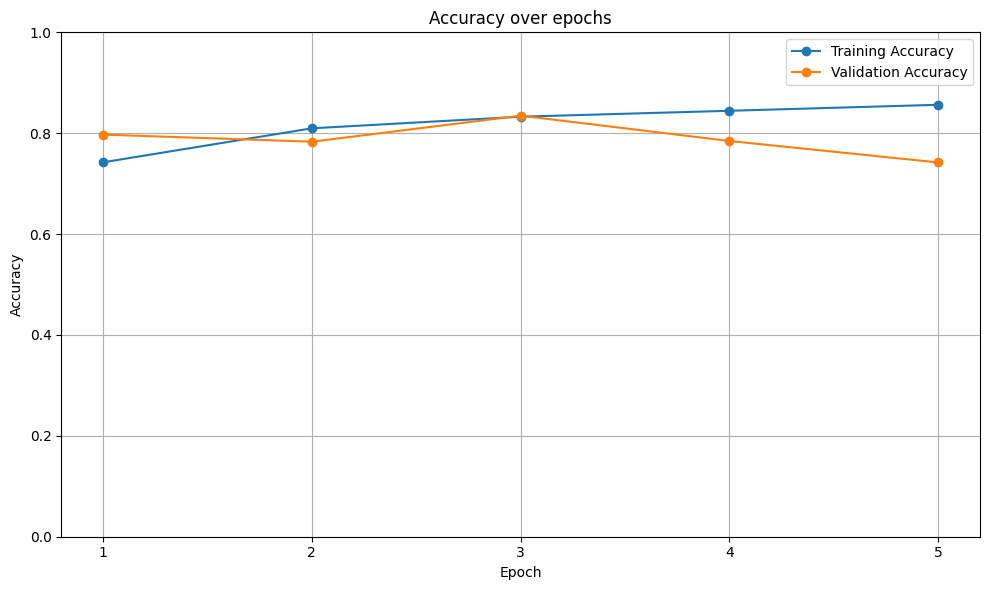

In [51]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, total_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs_range, total_val_accuracy, label='Validation Accuracy', marker='o')

plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
class SentimentClassifierRNN(nn.Module):
    def __init__(self, vocabulary_dimention, num_classes, hidden_dim, num_layers=1):
        super().__init__()

        self.embedding = nn.Embedding(vocabulary_dimention, 300)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(300, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        x = x.permute(1, 0, 2)
        _, (h_n, _) = self.lstm(x)
        final_hidden = torch.cat((h_n[-2], h_n[-1]), dim=1)
        out = self.fc(final_hidden)
        return out

In [55]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
modelRNN = SentimentClassifierRNN(len(tokens), num_classes=2, hidden_dim=64, num_layers=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(modelRNN.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'max', 0.5, 2, verbose=True)

epochs = 5
batch_size = 128

total_accuracy = list()
total_loss = list()
scaler = GradScaler()

train_accuracy, total_accuracy, total_loss, total_val_accuracy = train_model(epochs=epochs, model=modelRNN, scaler=scaler, 
                                                         criterion=criterion, optimizer=optimizer,
                                                           data_train=df_train, data_val=df_val, batch_size=128
                                                           , scheduler=scheduler
                                                           , num_unfreeze=8
                                                           )

test_accuracy, test_loss = evaluate_model(modelRNN, df_test, batch_size=128)
print("--------------")
print("Test accuracy: ", test_accuracy)

epoch:  {0}


361it [00:06, 53.17it/s]                         
78it [00:00, 101.21it/s]                        


Epoch 1: Loss = 0.0036, Accuracy = 0.7835, Val_accuracy = 0.8215, Val_loss = 0.0031
epoch:  {1}


361it [00:06, 56.00it/s]                         
78it [00:00, 101.21it/s]                        


Epoch 2: Loss = 0.0030, Accuracy = 0.8310, Val_accuracy = 0.8243, Val_loss = 0.0031
epoch:  {2}


361it [00:06, 55.86it/s]                         
78it [00:00, 102.67it/s]                        


Epoch 3: Loss = 0.0028, Accuracy = 0.8432, Val_accuracy = 0.8043, Val_loss = 0.0032
epoch:  {3}


361it [00:06, 55.73it/s]                         
78it [00:00, 102.00it/s]                        


Epoch 4: Loss = 0.0028, Accuracy = 0.8450, Val_accuracy = 0.7961, Val_loss = 0.0032
epoch:  {4}


361it [00:06, 55.17it/s]                         
78it [00:00, 100.94it/s]                        


Epoch 5: Loss = 0.0026, Accuracy = 0.8571, Val_accuracy = 0.8239, Val_loss = 0.0030


78it [00:00, 106.90it/s]                        

--------------
Test accuracy:  0.8178878221323901


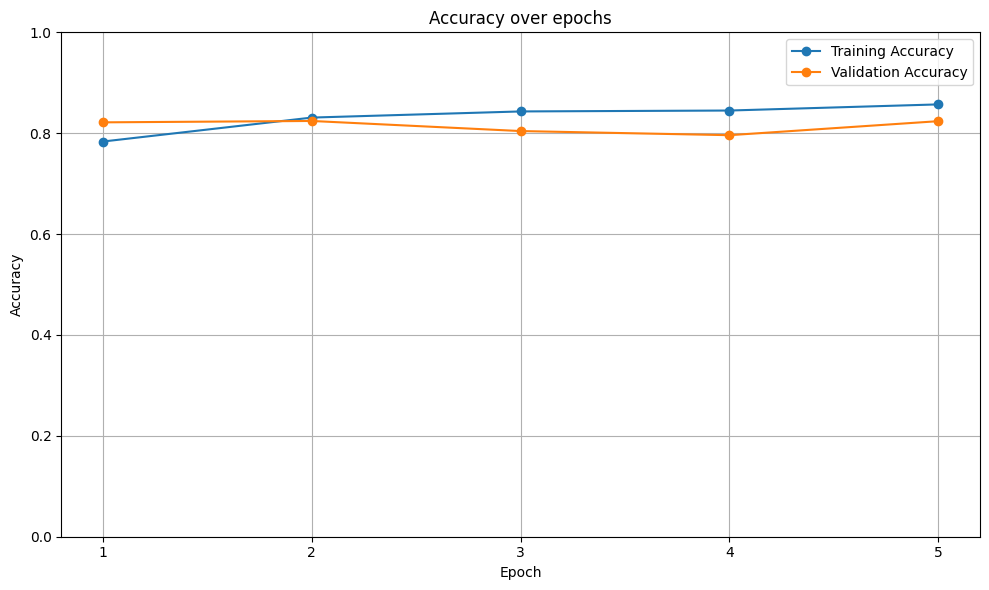

In [56]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, total_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs_range, total_val_accuracy, label='Validation Accuracy', marker='o')

plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can already see that these models are very, VERY prone to overfitting, specifically on this dataset. Becuase of that, we are not going to move onto more complex models, but are going to conclude this very brief notebook with the final accuracy analysis.

## Conclusion.

This was quite fast, wasn't it? Let's look at our results.

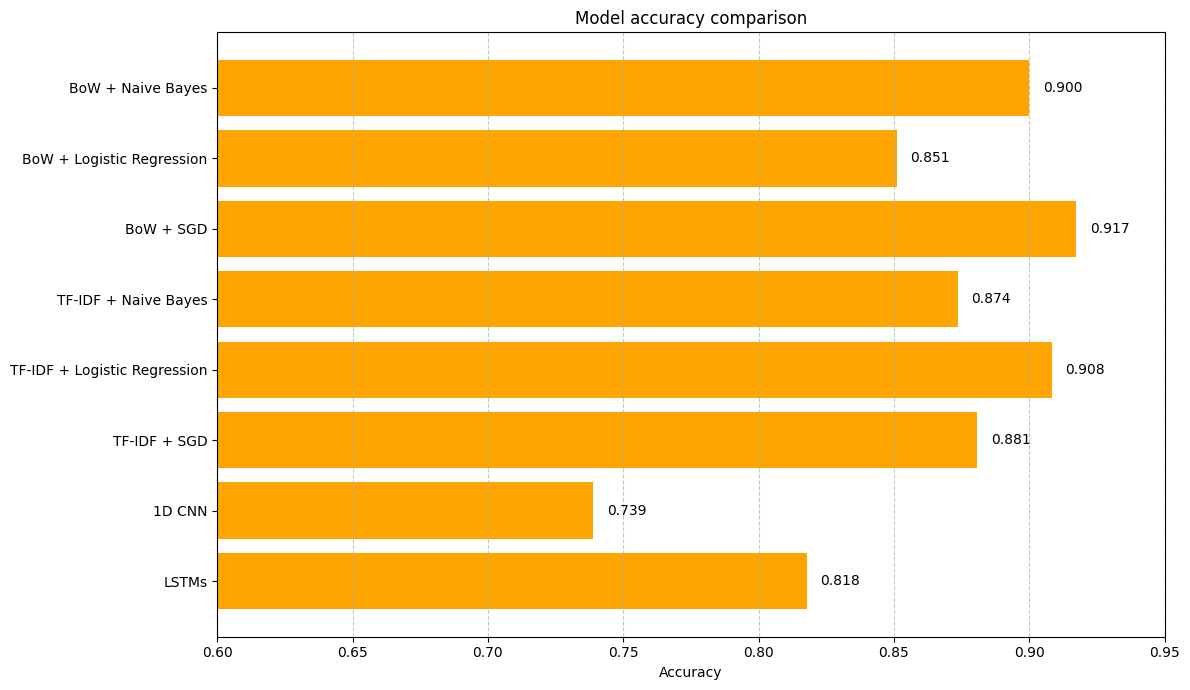

In [29]:
models = [
    "BoW + Naive Bayes",
    "BoW + Logistic Regression",
    "BoW + SGD",
    "TF-IDF + Naive Bayes",
    "TF-IDF + Logistic Regression",
    "TF-IDF + SGD",
    "1D CNN",
    "LSTMs"
]

accuracies = [
    0.8999494694290046,
    0.8511369378473976,
    0.917433046993431,
    0.8735725113693785,
    0.9083375442142496,
    0.8807478524507327,
    0.7389590702374936,
    0.8178878221323901
]

plt.figure(figsize=(12, 7))
bars = plt.barh(models, accuracies, color='orange')
plt.xlabel('Accuracy')
plt.title('Model accuracy comparison')
plt.xlim(0.6, 0.95)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center')

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

And our winner is BoW + SGD with 0.9174 accuracy! Hooray!

In [76]:
import joblib
joblib.dump(modelSGDBOW, "sgd_toxicity_classification.pkl")

['sgd_toxicity_classification.pkl']

In [78]:
joblib.dump(count_vectorizer, "toxic_count_vectorizer.pkl")

['toxic_count_vectorizer.pkl']